In [9]:
import dynamiqs as dq
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax
import optax
from tqdm import tqdm

# Optimize for 1 photon losses

In [3]:
N = 40
target_nbar = 4.0
learning_rate = 0.1
k1_o_k2 = 0.1
kphi_o_k2 = 1e-5

In [4]:
a = dq.destroy(N)
D, P = jnp.linalg.eigh((dq.dag(a) + a).asdense().data)
signX = P @ jnp.diag(jnp.sign(D)) @ dq.dag(P)

In [5]:
def compute_L(c0, c1, c2):
    a, ad = dq.destroy(N), dq.create(N)
    L = a @ a - c0 * dq.eye(N) + c1 * ad @ a + c2 * ad @ ad
    return L


def compute_cats(L):
    H_k = L.dag() @ L
    _, eigv = jnp.linalg.eigh(H_k.asdense().data)
    eigv = eigv.reshape((N, N, 1))
    first_plus = dq.expect(dq.parity(N), eigv[:, :, 0]).real > 0
    catp = jnp.where(first_plus, eigv[:, 0], eigv[:, 1])
    catm = jnp.where(~first_plus, eigv[:, 0], eigv[:, 1])
    return catp, catm


def compute_nbar(c0, c1, c2):
    catp, catm = compute_cats(compute_L(c0, c1, c2))
    a, ad = dq.destroy(N), dq.create(N)
    nbar = dq.expect(ad @ a, catp).real
    return nbar

In [14]:
@jax.jit
def optimize_nbar(c00, c1, c2):
    def cost(c0):
        nbar = compute_nbar(c0, c1, c2)
        return (nbar - target_nbar) ** 2

    grad_loss = jax.grad(cost)
    optimizer = optax.adam(learning_rate)
    init_params = jnp.array([c00])
    opt_state = optimizer.init(init_params)
    for i in range(50):
        grads = grad_loss(init_params)
        updates, opt_state = optimizer.update(grads, opt_state)
        init_params = optax.apply_updates(init_params, updates)
    return init_params

In [15]:
@jax.jit
def compute_bit_flip_time(params):
    c0 = optimize_nbar(target_nbar, *params)
    L = compute_L(c0, *params)
    a, ad = dq.destroy(N), dq.create(N)
    L1, Lphi = jnp.sqrt(k1_o_k2) * a, jnp.sqrt(kphi_o_k2 / 2) * ad @ a
    catp, catm = compute_cats(L)
    tmax = 20
    times = jnp.linspace(0, tmax, 100)
    output = dq.mesolve(
        0 * dq.eye(N),
        [L, L1, Lphi],
        dq.unit(catp + catm),
        times,
        exp_ops=[signX],
        options=dq.Options(save_states=False, progress_meter=None),
    )
    return -(output.expects[0][-1] / output.expects[0][0]).real

In [16]:
grad_bf = jax.value_and_grad(compute_bit_flip_time)
optimizer_bf = optax.adam(learning_rate)
init_params_bf = jnp.array([0.0, 0.0])
opt_state = optimizer_bf.init(init_params_bf)
params_history = [init_params_bf]
cost_history = []

In [17]:
for i in tqdm(range(10)):
    val, grad = grad_bf(init_params_bf)
    updates, opt_state = optimizer_bf.update(grad, opt_state)
    init_params_bf = optax.apply_updates(init_params_bf, updates)
    params_history.append(init_params_bf)
    cost_history.append(val)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [05:06<00:00, 30.68s/it]


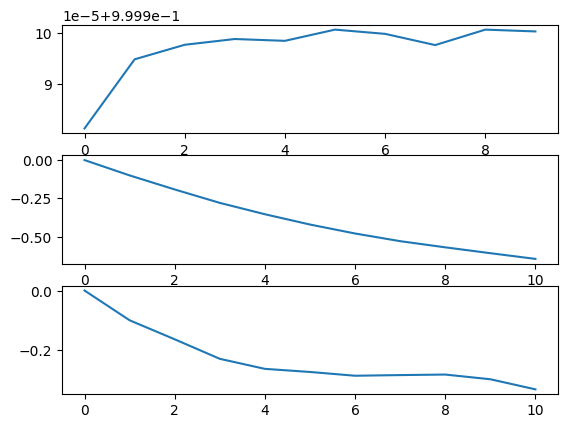

In [21]:
fig, ax = plt.subplots(3)
ax[0].plot(-jnp.array(cost_history))
ax[1].plot(-jnp.array(params_history)[:, 0])
ax[2].plot(-jnp.array(params_history)[:, 1])

In [22]:
for i in tqdm(range(50)):
    val, grad = grad_bf(init_params_bf)
    updates, opt_state = optimizer_bf.update(grad, opt_state)
    init_params_bf = optax.apply_updates(init_params_bf, updates)
    params_history.append(init_params_bf)
    cost_history.append(val)

100%|██████████| 50/50 [2:18:22<00:00, 166.05s/it]  


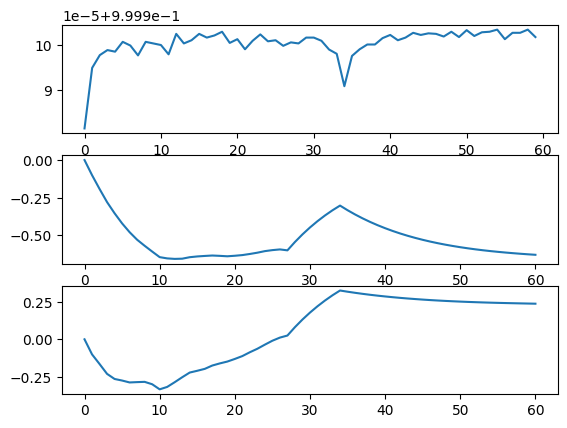

In [23]:
fig, ax = plt.subplots(3)
ax[0].plot(-jnp.array(cost_history))
ax[1].plot(-jnp.array(params_history)[:, 0])
ax[2].plot(-jnp.array(params_history)[:, 1])

In [28]:
c0 = optimize_nbar(4.0, *init_params_bf)

In [30]:
L = compute_L(c0, *init_params_bf)
catp, catm = compute_cats(L)

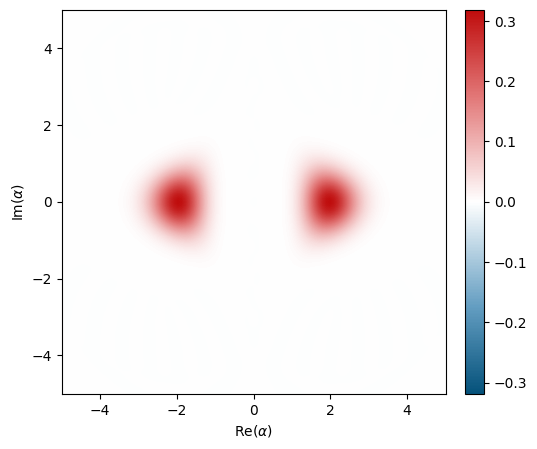

In [35]:
dq.plot.wigner((dq.todm(catp) + dq.todm(catm)) / 2, vmax=1 / jnp.pi)

# Optimize for dephasing

In [36]:
N = 40
target_nbar = 4.0
learning_rate = 0.1
k1_o_k2 = 1e-6
kphi_o_k2 = 0.1

In [37]:
a = dq.destroy(N)
D, P = jnp.linalg.eigh((dq.dag(a) + a).asdense().data)
signX = P @ jnp.diag(jnp.sign(D)) @ dq.dag(P)

In [38]:
def compute_L(c0, c1, c2):
    a, ad = dq.destroy(N), dq.create(N)
    L = a @ a - c0 * dq.eye(N) + c1 * ad @ a + c2 * ad @ ad
    return L


def compute_cats(L):
    H_k = L.dag() @ L
    _, eigv = jnp.linalg.eigh(H_k.asdense().data)
    eigv = eigv.reshape((N, N, 1))
    first_plus = dq.expect(dq.parity(N), eigv[:, :, 0]).real > 0
    catp = jnp.where(first_plus, eigv[:, 0], eigv[:, 1])
    catm = jnp.where(~first_plus, eigv[:, 0], eigv[:, 1])
    return catp, catm


def compute_nbar(c0, c1, c2):
    catp, catm = compute_cats(compute_L(c0, c1, c2))
    a, ad = dq.destroy(N), dq.create(N)
    nbar = dq.expect(ad @ a, catp).real
    return nbar

In [39]:
@jax.jit
def optimize_nbar(c00, c1, c2):
    def cost(c0):
        nbar = compute_nbar(c0, c1, c2)
        return (nbar - target_nbar) ** 2

    grad_loss = jax.grad(cost)
    optimizer = optax.adam(learning_rate)
    init_params = jnp.array([c00])
    opt_state = optimizer.init(init_params)
    for i in range(50):
        grads = grad_loss(init_params)
        updates, opt_state = optimizer.update(grads, opt_state)
        init_params = optax.apply_updates(init_params, updates)
    return init_params

In [40]:
@jax.jit
def compute_bit_flip_time(params):
    c0 = optimize_nbar(target_nbar, *params)
    L = compute_L(c0, *params)
    a, ad = dq.destroy(N), dq.create(N)
    L1, Lphi = jnp.sqrt(k1_o_k2) * a, jnp.sqrt(kphi_o_k2 / 2) * ad @ a
    catp, catm = compute_cats(L)
    tmax = 20
    times = jnp.linspace(0, tmax, 100)
    output = dq.mesolve(
        0 * dq.eye(N),
        [L, L1, Lphi],
        dq.unit(catp + catm),
        times,
        exp_ops=[signX],
        options=dq.Options(save_states=False, progress_meter=None),
    )
    return -(output.expects[0][-1] / output.expects[0][0]).real

In [41]:
grad_bf = jax.value_and_grad(compute_bit_flip_time)
optimizer_bf = optax.adam(learning_rate)
init_params_bf = jnp.array([0.0, 0.0])
opt_state = optimizer_bf.init(init_params_bf)
params_history = [init_params_bf]
cost_history = []

In [42]:
for i in tqdm(range(10)):
    val, grad = grad_bf(init_params_bf)
    updates, opt_state = optimizer_bf.update(grad, opt_state)
    init_params_bf = optax.apply_updates(init_params_bf, updates)
    params_history.append(init_params_bf)
    cost_history.append(val)

100%|██████████| 10/10 [05:40<00:00, 34.09s/it]


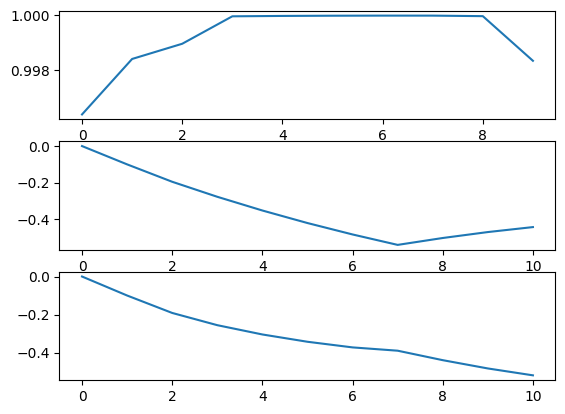

In [43]:
fig, ax = plt.subplots(3)
ax[0].plot(-jnp.array(cost_history))
ax[1].plot(-jnp.array(params_history)[:, 0])
ax[2].plot(-jnp.array(params_history)[:, 1])

In [44]:
for i in tqdm(range(50)):
    val, grad = grad_bf(init_params_bf)
    updates, opt_state = optimizer_bf.update(grad, opt_state)
    init_params_bf = optax.apply_updates(init_params_bf, updates)
    params_history.append(init_params_bf)
    cost_history.append(val)

100%|██████████| 50/50 [39:38<00:00, 47.58s/it] 


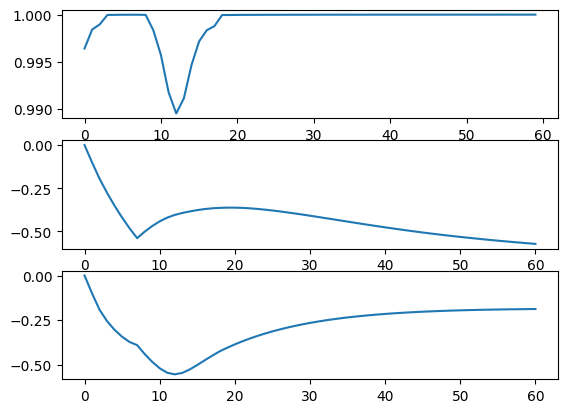

In [45]:
fig, ax = plt.subplots(3)
ax[0].plot(-jnp.array(cost_history))
ax[1].plot(-jnp.array(params_history)[:, 0])
ax[2].plot(-jnp.array(params_history)[:, 1])

In [46]:
c0 = optimize_nbar(4.0, *init_params_bf)

In [47]:
L = compute_L(c0, *init_params_bf)
catp, catm = compute_cats(L)

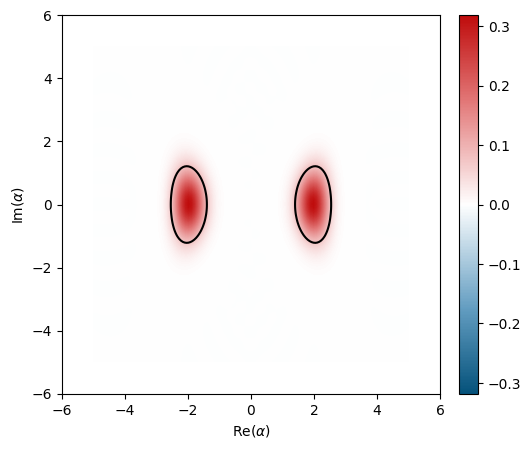

In [50]:
dq.plot.wigner((dq.todm(catp) + dq.todm(catm)) / 2, vmax=1 / jnp.pi)
x, y, w = dq.wigner(dq.todm(catp) + dq.todm(catm))
plt.contour(x, y, w.T, levels=[0.5 / jnp.pi], colors="k")